In [1]:
"""
Purpose: To run the soma splitting 
on the processed neurons

"""


'\nPurpose: To run the soma splitting \non the processed neurons\n\n'

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")

from importlib import reload

In [3]:
import datajoint_utils as du

INFO - 2021-01-19 03:15:57,315 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-19 03:15:57,316 - settings - Setting database.user to celiib
INFO - 2021-01-19 03:15:57,316 - settings - Setting database.password to newceliipass
INFO - 2021-01-19 03:15:57,326 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-01-19 03:15:57,327 - settings - Setting enable_python_native_blobs to True
INFO - 2021-01-19 03:15:57,337 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-01-19 03:15:57,617 - settings - Setting enable_python_native_blobs to True


In [4]:
test_mode = True

In [5]:
import minfig
import time
import numpy as np
#want to add in a wait for the connection part
random_sleep_sec = np.random.randint(0, 200)
print(f"Sleeping {random_sleep_sec} sec before conneting")
if not test_mode:
    time.sleep(random_sleep_sec)
print("Done sleeping")

du.config_celii()
du.set_minnie65_config_segmentation(minfig)
du.print_minnie65_config_paths(minfig)

#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-01-19 03:15:57,651 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-19 03:15:57,652 - settings - Setting database.user to celiib
INFO - 2021-01-19 03:15:57,653 - settings - Setting database.password to newceliipass
INFO - 2021-01-19 03:15:57,655 - settings - Setting enable_python_native_blobs to True


Sleeping 41 sec before conneting
Done sleeping
Current path for external_segmentation_path = /mnt/dj-stor01/platinum/minnie65/02
Current path for external_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/meshes
Current path for external_decimated_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/decimated_meshes
Current path for external_skeleton_path = /mnt/dj-stor01/platinum/minnie65/02/skeletons


INFO - 2021-01-19 03:15:57,933 - settings - Setting enable_python_native_blobs to True


# Defining the Table

In [6]:
import neuron_utils as nru
import neuron
import trimesh_utils as tu
import numpy as np

In [7]:
import meshlab
meshlab.set_meshlab_port(current_port=None)

No port chosen so picked random port 1212


In [8]:
#so that it will have the adapter defined
from datajoint_utils import DecompositionAdapter

In [9]:
import numpy as np
import time
import proofreading_utils as pru

@schema
class NeuronSplitSuggestions(dj.Computed):
    definition="""
    -> minnie.Decomposition
    ---
    split_results: longblob #will store the results of how to split the limbs of neuron objects
    run_time=NULL : double                   # the amount of time to run (seconds)

    """

    key_source = minnie.Decomposition() & minnie.MultiSomaProofread2.proj()
    
    def make(self,key):
        """
        Pseudocode for process:

        1) Fetch the neuron object
        2) Run the mutli-split suggestions
        3) Calculate the total time
        4) Write the results to the table
        """
        whole_pass_time = time.time()
        #1) Get the segment id from the key
        segment_id = key["segment_id"]
        print(f"\n\n----- Working on Neuron {segment_id}-------")
        
        neuron_obj = (minnie.Decomposition & key).fetch1("decomposition")
        
        limb_results = pru.multi_soma_split_suggestions(neuron_obj,plot_intermediates=False)
        
        #7) Pass stats and file location to insert
        new_key = dict(key,
                       split_results = limb_results,
                       run_time=np.round(time.time() - whole_pass_time,4)
                      )

        self.insert1(new_key, allow_direct_insert=True, skip_duplicates=True)

        print(f"\n\n ------ Total time for Splitting {segment_id} = {time.time() - whole_pass_time} ------")
    

# Running the Populate

In [10]:
curr_table = (minnie.schema.jobs & "table_name='__neuron_split_suggestions'")
(curr_table)#.delete()# & "status='error'")
#curr_table.delete()
#(curr_table & "error_message = 'ValueError: need at least one array to concatenate'").delete()

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__neuron_split_suggestions,2780b8fac28058d79ec92cb360ccb2d6,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,32522,53503,2021-01-18 21:14:54
__neuron_split_suggestions,5453421d86ee5dd7d7209e49dedc205e,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,317,53507,2021-01-18 21:15:26
__neuron_split_suggestions,994bf9403e5bc2fb25a3666b4a6446f5,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,32396,53500,2021-01-18 21:15:51
__neuron_split_suggestions,bb27471bdf6ca6d0feeaee1c45e4498b,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,32631,53505,2021-01-18 21:15:12
__neuron_split_suggestions,dcd361f29ba0cff26aac4265a115c6c3,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,32459,53501,2021-01-18 21:14:32


In [11]:
minnie.NeuronSplitSuggestions()

segment_id segment id unique within each Segmentation,decimation_version,decimation_ratio ratio of remaining mesh vertices/faces (which ones depends on what metric the decimation technique uses),ver the version number of the materializaiton,process_version the version of the preprocessing pipeline run,index the index of the neuron object that resulted from that mesh (indexed starting at 0),split_results will store the results of how to split the limbs of neuron objects,run_time the amount of time to run (seconds)
864691134947393276,0,0.25,29.00,0,0,=BLOB=,95.2768


INFO - 2021-01-19 03:15:58,064 - autopopulate - Found 48 keys to populate
INFO - 2021-01-19 03:15:58,080 - connection - Transaction started
INFO - 2021-01-19 03:15:58,081 - autopopulate - Populating: {'segment_id': 864691135081756919, 'decimation_version': 0, 'decimation_ratio': Decimal('0.25'), 'ver': Decimal('29.00'), 'process_version': 0, 'index': 0}


Populate Started


----- Working on Neuron 864691135081756919-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [0 1]


 -------- Working on limb 0------------
Starting combinations to process = [[ 34  45]
 [ 34  50]
 [ 34  52]
 [ 34  75]
 [ 34  77]
 [ 34  82]
 [ 34 104]
 [ 45  50]
 [ 45  52]
 [ 45  75]
 [ 45  77]
 [ 45  82]
 [ 45 104]
 [ 50  52]
 [ 50  75]
 [ 50  77]
 [ 50  82]
 [ 50 104]
 [ 52  75]
 [ 52  77]
 [ 52  82]
 [ 52 104]
 [ 75  77]
 [ 75  82]
 [ 75 104]
 [ 77  82]
 [ 77 104]
 [ 82 104]]


---- working on disconnecting 34 and 45
---- This disconnects S0_3 from S0_5  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [34, 25, 24, 36, 46, 45]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_removal is set so segments_to_consider = [ 1 16 24 25 26 27 

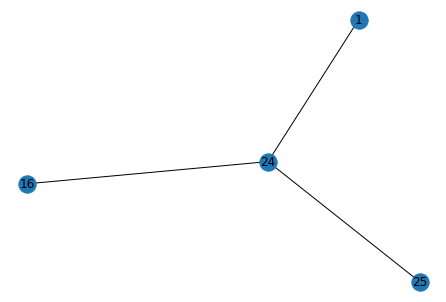

match_branches = [[1, 25], [16, 24]]
edges_to_delete (resolve crossover) = [[1, 16], [1, 24], [16, 25], [24, 25]]
edges_to_create (resolve crossover) = [[1, 25], [16, 24]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 16], [1, 24], [16, 25], [24, 25]]
edges_to_create = [[1, 25], [16, 24]]
Number of connected components = 1
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146

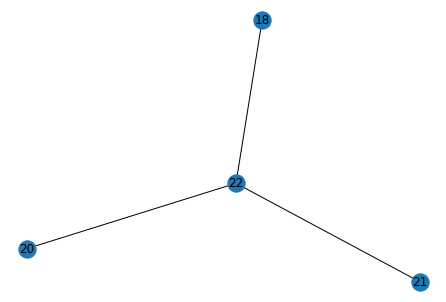

match_branches = [[20, 22]]
edges_to_delete (resolve crossover) = [[18, 20], [18, 21], [18, 22], [20, 21], [21, 22]]
edges_to_create (resolve crossover) = [[20, 22]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 22 because skeletal distance was 1757.5637710071646 and threshold was 2500
skip_nodes = [22]
edges_to_delete (cut_limb_network) = [[18, 20], [18, 21], [18, 22], [20, 21], [21, 22]]
edges_to_create = [[20, 22]]
Number of connected components = 4
Comp 0 = {6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 20, 22, 23, 24, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52}
Comp 1 = {0, 1, 2, 3, 4, 5, 12, 16, 18}
Comp 2 = {25, 29, 21, 30}
Comp 3 = {19}
curr_limb_copy.deleted_edges = [[18, 20], [18, 21], [18, 22], [20, 21], [21, 22]]
curr_limb_copy.created_edges = [[20, 22]]
After get best cut: cut_edges = [[18, 20], [18, 21], [18, 22], [20, 21], [21, 22]], added_edges = [[20, 22]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cu

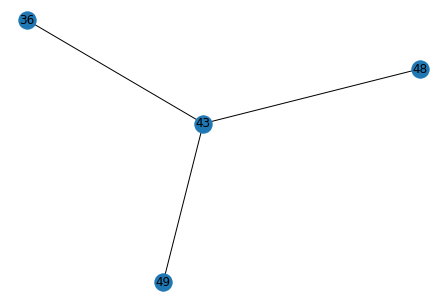

match_branches = [[43, 48]]
edges_to_delete (resolve crossover) = [[36, 43], [36, 48], [36, 49], [43, 49], [48, 49]]
edges_to_create (resolve crossover) = [[43, 48]]
curr_limb.deleted_edges 5 =[[18, 20], [18, 21], [18, 22], [20, 21], [21, 22]]
Skipping endnode 22 because skeletal distance was 1757.5637710071646 and threshold was 2500
skip_nodes = [22]
edges_to_delete (cut_limb_network) = [[36, 43], [36, 48], [36, 49], [43, 49], [48, 49]]
edges_to_create = [[43, 48]]
Number of connected components = 6
Comp 0 = {6, 7, 8, 9, 10, 13, 14, 15, 17, 24, 26, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 51, 52}
Comp 1 = {43, 44, 11, 48, 20, 22, 23, 27, 28}
Comp 2 = {49, 50, 47}
Comp 3 = {0, 1, 2, 3, 4, 5, 12, 16, 18}
Comp 4 = {25, 29, 21, 30}
Comp 5 = {19}
curr_limb_copy.deleted_edges = [[18, 20], [18, 21], [18, 22], [20, 21], [21, 22], [36, 43], [36, 48], [36, 49], [43, 49], [48, 49]]
curr_limb_copy.created_edges = [[20, 22], [43, 48]]
After get best cut: cut_edges = [[36, 43], [36, 

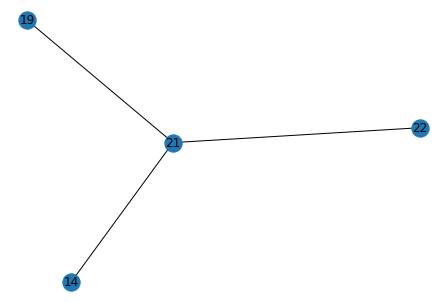

match_branches = [[19, 22], [14, 21]]
edges_to_delete (resolve crossover) = [[14, 19], [14, 22], [19, 21], [21, 22]]
edges_to_create (resolve crossover) = [[19, 22], [14, 21]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 34 because skeletal distance was 169.7821189238401 and threshold was 2500
skip_nodes = [34]
edges_to_delete (cut_limb_network) = [[14, 19], [14, 22], [19, 21], [21, 22]]
edges_to_create = [[19, 22], [14, 21]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 19, 22, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78}
Comp 1 = {9, 14, 21, 23, 25, 26}
Comp 2 = {20}
Comp 3 = {63}
curr_limb_copy.deleted_edges = [[14, 19], [14, 22], [19, 21], [21, 22]]
curr_limb_copy.created_edges = [[19, 22], [14, 21]]
After get best cut: cut_edges = [[14, 19], [14, 22], [19, 21], 

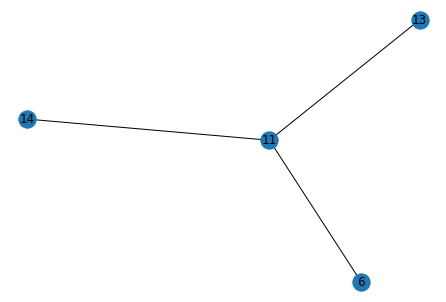

match_branches = [[11, 14], [6, 13]]
edges_to_delete (resolve crossover) = [[6, 11], [6, 14], [11, 13], [13, 14]]
edges_to_create (resolve crossover) = [[11, 14], [6, 13]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[6, 11], [6, 14], [11, 13], [13, 14]]
edges_to_create = [[11, 14], [6, 13]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 8, 9, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27.0, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}
Comp 1 = {10, 11, 14, 7}
Comp 2 = {12}
curr_limb_copy.deleted_edges = [[6, 11], [6, 14], [11, 13], [13, 14]]
curr_limb_copy.created_edges = [[11, 14], [6, 13]]
After get best cut: cut_edges = [[6, 11], [6, 14], [11, 13], [13, 14]], added_edges = [[11, 14], [6, 13]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end

  Edge: [41 37]: curr_angle = 39.75
  Edge: [37 29]: curr_angle = 28.93
  Edge: [29 26]: curr_angle = 22.34
  Edge: [26 35]: curr_angle = 143.19
  Edge: [35 36]: curr_angle = 29.32
  Edge: [36 42]: curr_angle = 33.86

Total time for doubling_back = 0.3216872215270996
There were 1 edges that passed doubling back threshold of 100
Winning edge [26 35] had a doubling back of 143.19231706392713
***inside resolve crossover!!!!****
coordinate_branches = [26, 32, 35]
26 = red
32 = aqua
35 = purple
Angle between 26 and 32 = 13.97 
Angle between 26 and 35 = 161.33 
Angle between 32 and 35 = 25.25 
Final Matches = [[26, 32], [32, 35]]
matched_branches_revised = [[26, 32]]
Original graph


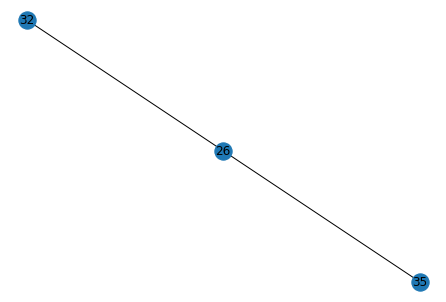

match_branches = [[26, 32]]
edges_to_delete (resolve crossover) = [[26, 35], [32, 35]]
edges_to_create (resolve crossover) = [[26, 32]]
edges_to_delete (cut_limb_network) = [array([26, 35]), array([32, 35])]
edges_to_create = [[26, 32]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 8, 9, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27.0, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 44, 45, 46, 47, 48, 49}
Comp 1 = {35, 36, 6, 42, 43, 13}
Comp 2 = {10, 11, 14, 7}
Comp 3 = {12}
curr_limb_copy.deleted_edges = [[6, 11], [6, 14], [11, 13], [13, 14], array([26, 35]), array([32, 35])]
curr_limb_copy.created_edges = [[11, 14], [6, 13], [26, 32]]
After get best cut: cut_edges = [array([26, 35]), array([32, 35])], added_edges = [[26, 32]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so m

  Edge: [18 11]: curr_angle = 55.89
  Edge: [11  9]: curr_angle = 99.36
  Edge: [9 8]: curr_angle = 82.44
  Edge: [ 8 29]: curr_angle = 34.55
  Edge: [29 21]: curr_angle = 112.66

Total time for doubling_back = 2.1054112911224365
There were 1 edges that passed doubling back threshold of 100
Winning edge [29 21] had a doubling back of 112.66311850803625
***inside resolve crossover!!!!****
coordinate_branches = [21, 27, 29]
21 = red
27 = aqua
29 = purple
Angle between 21 and 27 = 36.97 
Angle between 21 and 29 = 116.45 
Angle between 27 and 29 = 69.15 
Final Matches = []
matched_branches_revised = []
Original graph


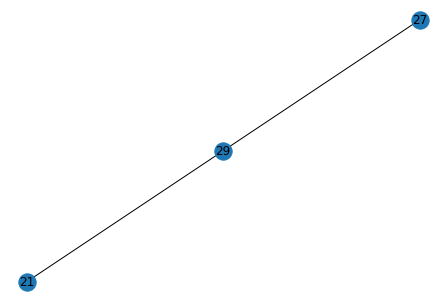

match_branches = []
edges_to_delete (resolve crossover) = [[21, 27], [21, 29], [27, 29]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([21, 27]), array([21, 29]), array([27, 29])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 16, 17, 18, 29, 30}
Comp 1 = {21}
Comp 2 = {0, 7, 14, 15, 19, 20, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38}
curr_limb_copy.deleted_edges = [array([21, 27]), array([21, 29]), array([27, 29])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([21, 27]), array([21, 29]), array([27, 29])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 18 and 34
---- This disconnec

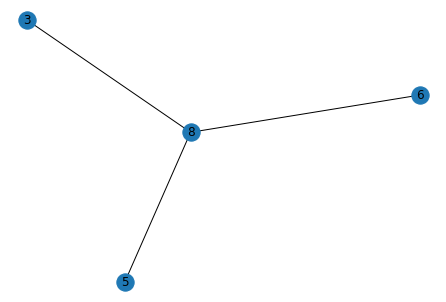

match_branches = [[6, 8]]
edges_to_delete (resolve crossover) = [[3, 5], [3, 6], [3, 8], [5, 6], [5, 8]]
edges_to_create (resolve crossover) = [[6, 8]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 6 because skeletal distance was 804.872506722476 and threshold was 2500
skip_nodes = [6]
edges_to_delete (cut_limb_network) = [[3, 5], [3, 6], [3, 8], [5, 6], [5, 8]]
edges_to_create = [[6, 8]]
Number of connected components = 4
Comp 0 = {1, 2, 6, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
Comp 1 = {0, 3, 4}
Comp 2 = {13, 12, 5}
Comp 3 = {7}
curr_limb_copy.deleted_edges = [[3, 5], [3, 6], [3, 8], [5, 6], [5, 8]]
curr_limb_copy.created_edges = [[6, 8]]
After get best cut: cut_edges = [[3, 5], [3, 6], [3, 8], [5, 6], [5, 8]], added_edges = [[6, 8]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No va

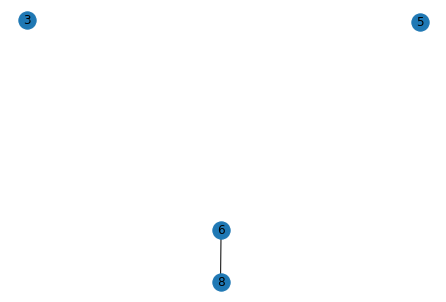

match_branches = [[6, 8]]
edges_to_delete (resolve crossover) = [[3, 5], [3, 6], [3, 8], [5, 6], [5, 8]]
edges_to_create (resolve crossover) = [[6, 8]]
curr_limb.deleted_edges 5 =[[3, 5], [3, 6], [3, 8], [5, 6], [5, 8]]
Skipping endnode 6 because skeletal distance was 804.872506722476 and threshold was 2500
skip_nodes = [6]
edges_to_delete (cut_limb_network) = [[3, 5], [3, 6], [3, 8], [5, 6], [5, 8]]
edges_to_create = [[6, 8]]
Number of connected components = 4
Comp 0 = {1, 2, 6, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
Comp 1 = {0, 3, 4}
Comp 2 = {13, 12, 5}
Comp 3 = {7}
curr_limb_copy.deleted_edges = [[3, 5], [3, 6], [3, 8], [5, 6], [5, 8], [3, 5], [3, 6], [3, 8], [5, 6], [5, 8]]
curr_limb_copy.created_edges = [[6, 8], [6, 8]]
After get best cut: cut_edges = [[3, 5], [3, 6], [3, 8], [5, 6], [5, 8]], added_edges = [[6, 8]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRE

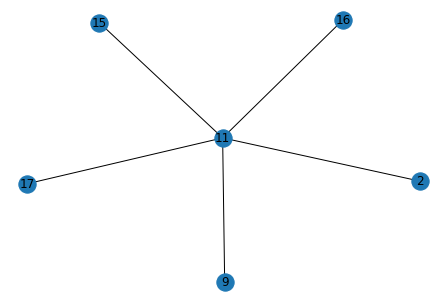

match_branches = [[11, 15], [9, 17]]
edges_to_delete (resolve crossover) = [[2, 9], [2, 11], [2, 15], [2, 16], [2, 17], [9, 11], [9, 15], [9, 16], [11, 16], [11, 17], [15, 16], [15, 17], [16, 17]]
edges_to_create (resolve crossover) = [[11, 15], [9, 17]]
curr_limb.deleted_edges 5 =[[3, 5], [3, 6], [3, 8], [5, 6], [5, 8], [3, 5], [3, 6], [3, 8], [5, 6], [5, 8]]
Skipping endnode 6 because skeletal distance was 804.872506722476 and threshold was 2500
skip_nodes = [6]
edges_to_delete (cut_limb_network) = [[2, 9], [2, 11], [2, 15], [2, 16], [2, 17], [9, 11], [9, 15], [9, 16], [11, 16], [11, 17], [15, 16], [15, 17], [16, 17]]
edges_to_create = [[11, 15], [9, 17]]
Number of connected components = 7
Comp 0 = {1, 6, 8, 10, 11, 14, 15}
Comp 1 = {0, 3, 4}
Comp 2 = {13, 12, 5}
Comp 3 = {2}
Comp 4 = {9, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
Comp 5 = {16}
Comp 6 = {7}
curr_limb_copy.deleted_edges = [[3, 5], [3, 6], [3, 8], [5, 6], [5, 8], [3, 5], [3, 6], [3, 8], [5, 6], [5, 8], [2, 9], [2, 11], [2

  Edge: [6 7]: curr_angle = 149.97
  Edge: [7 9]: curr_angle = 22.98
  Edge: [ 9 10]: curr_angle = 30.12
  Edge: [10  2]: curr_angle = 119.42
  Edge: [2 3]: curr_angle = 95.92
  Edge: [3 8]: curr_angle = 154.86

Total time for doubling_back = 0.4192190170288086
There were 3 edges that passed doubling back threshold of 100
Winning edge [3 8] had a doubling back of 154.863421183941
***inside resolve crossover!!!!****
coordinate_branches = [0, 3, 8]
0 = red
3 = aqua
8 = purple
Angle between 0 and 3 = 91.64 
Angle between 0 and 8 = 43.32 
Angle between 3 and 8 = 58.32 
Final Matches = []
matched_branches_revised = []
Original graph


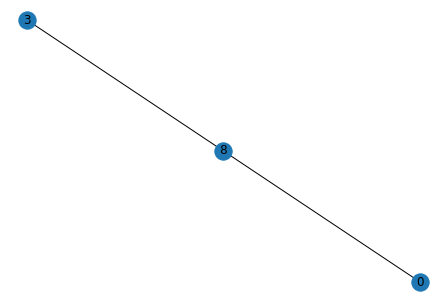

match_branches = []
edges_to_delete (resolve crossover) = [[0, 3], [0, 8], [3, 8]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([0, 3]), array([0, 8]), array([3, 8])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}
Comp 1 = {0}
Comp 2 = {8}
curr_limb_copy.deleted_edges = [array([0, 3]), array([0, 8]), array([3, 8])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([0, 3]), array([0, 8]), array([3, 8])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection


---- working on disconnecting 6 and 17
---- This disconnects S1_1 from S0_0  
 Cut iteration 0
Tota

  Edge: [6 7]: curr_angle = 30.89
  Edge: [7 9]: curr_angle = 22.98
  Edge: [ 9 10]: curr_angle = 30.12
  Edge: [10  2]: curr_angle = 119.42
  Edge: [ 2 12]: curr_angle = 19.04
  Edge: [12 19]: curr_angle = 37.7
  Edge: [19 18]: curr_angle = 18.83
  Edge: [18 17]: curr_angle = 21.76

Total time for doubling_back = 0.5738530158996582
There were 1 edges that passed doubling back threshold of 100
Winning edge [10  2] had a doubling back of 119.42416722060605
***inside resolve crossover!!!!****
coordinate_branches = [2, 10, 12]
2 = red
10 = aqua
12 = purple
Angle between 2 and 10 = 123.64 
Angle between 2 and 12 = 26.68 
Angle between 10 and 12 = 81.28 
Final Matches = [[2, 12]]
matched_branches_revised = [[2, 12]]
Original graph


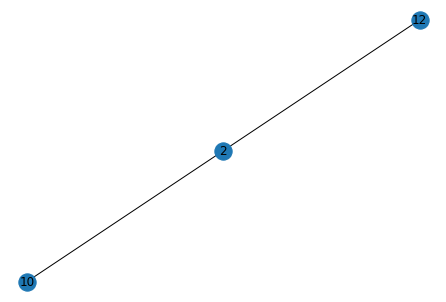

match_branches = [[2, 12]]
edges_to_delete (resolve crossover) = [[2, 10], [10, 12]]
edges_to_create (resolve crossover) = [[2, 12]]
edges_to_delete (cut_limb_network) = [array([ 2, 10]), array([10, 12])]
edges_to_create = [[2, 12]]
Number of connected components = 4
Comp 0 = {1, 2, 3, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}
Comp 1 = {4, 5, 6, 7, 9, 10, 11, 13, 14}
Comp 2 = {0}
Comp 3 = {8}
curr_limb_copy.deleted_edges = [array([0, 3]), array([0, 8]), array([3, 8]), array([ 2, 10]), array([10, 12])]
curr_limb_copy.created_edges = [[2, 12]]
After get best cut: cut_edges = [array([ 2, 10]), array([10, 12])], added_edges = [[2, 12]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 4
Total number of graphs at the end of the split AFTER DIRECTIONAL = 4
No valid path so moving onto the next connection


---- working on disconnecting 8 and 17
---- Thi

  Edge: [37 30]: curr_angle = 20.24
  Edge: [30 24]: curr_angle = 29.74
  Edge: [24 25]: curr_angle = 38.18
  Edge: [25 26]: curr_angle = 31.91
  Edge: [26 29]: curr_angle = 1.8
  Edge: [29 31]: curr_angle = 47.63
  Edge: [31 43]: curr_angle = 60.24
  Edge: [43 34]: curr_angle = 20.03
  Edge: [34 48]: curr_angle = 37.97
  Edge: [48 39]: curr_angle = 43.7
  Edge: [39 35]: curr_angle = 19.5
  Edge: [35 32]: curr_angle = 26.78
  Edge: [32 33]: curr_angle = 34.17
  Edge: [33 42]: curr_angle = 19.9

Total time for doubling_back = 1.3198425769805908

Attempting the width jump check (attempting from both sides)
  Edge: [37 30]: jump = -119.74
  Edge: [30 24]: jump = -191.22
  Edge: [24 25]: jump = -167.31
  Edge: [25 26]: jump = 46.72
  Edge: [26 29]: jump = -111.84
  Edge: [29 31]: jump = -181.18
  Edge: [31 43]: jump = 55.14
  Edge: [43 34]: jump = -29.56
  Edge: [34 48]: jump = -20.69
  Edge: [48 39]: jump = 209.35
Adding error edge [48 39] because width jump was 209.34737324410543
  Edge:

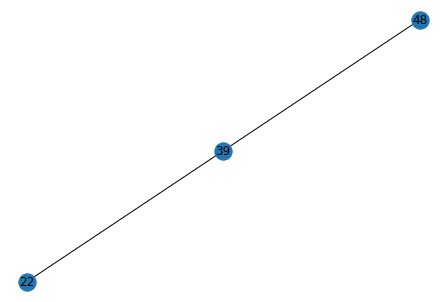

match_branches = []
edges_to_delete (resolve crossover) = [[22, 39], [22, 48], [39, 48]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([22, 39]), array([22, 48]), array([39, 48])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {2, 3, 7, 8, 10, 12, 13, 14, 15, 16, 19, 21, 27, 32, 33, 35, 39, 40, 41, 42, 44, 45, 47, 49, 50, 51, 55, 56, 57}
Comp 1 = {22}
Comp 2 = {0, 1, 4, 5, 6, 9, 11, 17, 18, 20, 23, 24, 25, 26, 28, 29, 30, 31, 34, 36, 37, 38, 43, 46, 48, 52, 53, 54, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77}
curr_limb_copy.deleted_edges = [array([22, 39]), array([22, 48]), array([39, 48])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([22, 39]), array([22, 48]), array([39, 48])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs 

  Edge: [37 30]: curr_angle = 20.24
  Edge: [30 24]: curr_angle = 29.74
  Edge: [24 25]: curr_angle = 38.18
  Edge: [25 26]: curr_angle = 31.91
  Edge: [26 29]: curr_angle = 1.8
  Edge: [29 31]: curr_angle = 47.63
  Edge: [31 43]: curr_angle = 60.24
  Edge: [43 36]: curr_angle = 75.77
  Edge: [36 61]: curr_angle = 16.64
  Edge: [61 59]: curr_angle = 10.42
  Edge: [59 69]: curr_angle = 15.64
  Edge: [69 63]: curr_angle = 26.06
  Edge: [63 64]: curr_angle = 33.93

Total time for doubling_back = 2.080947160720825

Attempting the width jump check (attempting from both sides)
  Edge: [37 30]: jump = -119.74
  Edge: [30 24]: jump = -191.22
  Edge: [24 25]: jump = -167.31
  Edge: [25 26]: jump = 46.72
  Edge: [26 29]: jump = -111.84
  Edge: [29 31]: jump = -181.18
  Edge: [31 43]: jump = 55.14
  Edge: [43 36]: jump = -227.48
  Edge: [36 61]: jump = 49.61
  Edge: [61 59]: jump = 215.14
Adding error edge [61 59] because width jump was 215.14239529429665
  Edge: [59 69]: jump = 71.13
  Edge: [69

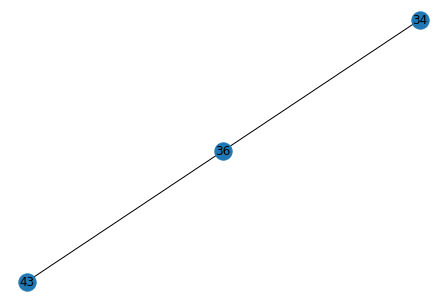

match_branches = [[34, 43]]
edges_to_delete (resolve crossover) = [[34, 36], [36, 43]]
edges_to_create (resolve crossover) = [[34, 43]]
edges_to_delete (cut_limb_network) = [array([34, 36]), array([36, 43])]
edges_to_create = [[34, 43]]
Number of connected components = 4
Comp 0 = {2, 3, 7, 8, 10, 12, 13, 14, 15, 16, 19, 21, 27, 32, 33, 35, 39, 40, 41, 42, 44, 45, 47, 49, 50, 51, 55, 56, 57}
Comp 1 = {22}
Comp 2 = {0, 1, 4, 5, 9, 11, 17, 18, 20, 23, 24, 25, 26, 28, 29, 30, 31, 34, 37, 38, 43, 46, 48, 52, 53, 54, 58, 65}
Comp 3 = {64, 66, 67, 36, 69, 70, 71, 72, 68, 73, 74, 6, 75, 76, 77, 59, 60, 61, 62, 63}
curr_limb_copy.deleted_edges = [array([22, 39]), array([22, 48]), array([39, 48]), array([34, 36]), array([36, 43])]
curr_limb_copy.created_edges = [[34, 43]]
After get best cut: cut_edges = [array([34, 36]), array([36, 43])], added_edges = [[34, 43]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE

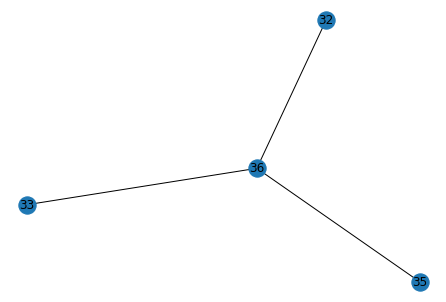

match_branches = [[33, 35], [32, 36]]
edges_to_delete (resolve crossover) = [[32, 33], [32, 35], [33, 36], [35, 36]]
edges_to_create (resolve crossover) = [[33, 35], [32, 36]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 42 because skeletal distance was 667.7304046780656 and threshold was 2500
skip_nodes = [42]
edges_to_delete (cut_limb_network) = [[32, 33], [32, 35], [33, 36], [35, 36]]
edges_to_create = [[33, 35], [32, 36]]
Number of connected components = 3
Comp 0 = {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 33, 35, 37, 38, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67}
Comp 1 = {2, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 36, 39}
Comp 2 = {34}
curr_limb_copy.deleted_edges = [[32, 33], [32, 35], [33, 36], [35, 36]]
curr_limb_copy.created_edges = [[33, 35], [32, 36]]
After get best cut: cut_edges = [[32, 33], [32, 35], [33, 36], [35, 36]], added_edges = [[33, 35], [32, 36]]
total_so

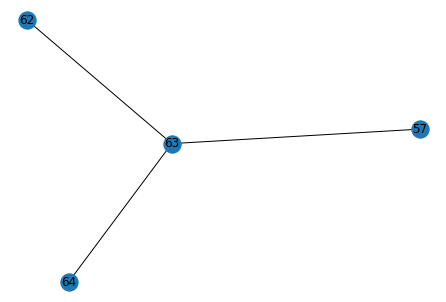

match_branches = [[62, 63], [57, 64]]
edges_to_delete (resolve crossover) = [[57, 62], [57, 63], [62, 64], [63, 64]]
edges_to_create (resolve crossover) = [[62, 63], [57, 64]]
curr_limb.deleted_edges 5 =[[32, 33], [32, 35], [33, 36], [35, 36]]
Skipping endnode 42 because skeletal distance was 667.7304046780656 and threshold was 2500
skip_nodes = [42]
edges_to_delete (cut_limb_network) = [[57, 62], [57, 63], [62, 64], [63, 64]]
edges_to_create = [[62, 63], [57, 64]]
Number of connected components = 4
Comp 0 = {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 33, 35, 37, 38, 40, 41, 42, 45, 48, 49, 51, 55, 58, 59, 60, 61, 62, 63, 65, 66}
Comp 1 = {2, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 36, 39}
Comp 2 = {64, 67, 43, 44, 46, 47, 50, 52, 53, 54, 56, 57}
Comp 3 = {34}
curr_limb_copy.deleted_edges = [[32, 33], [32, 35], [33, 36], [35, 36], [57, 62], [57, 63], [62, 64], [63, 64]]
curr_limb_copy.created_edges = [[33, 35], [32, 36], [62, 63], [57, 64]]
After get

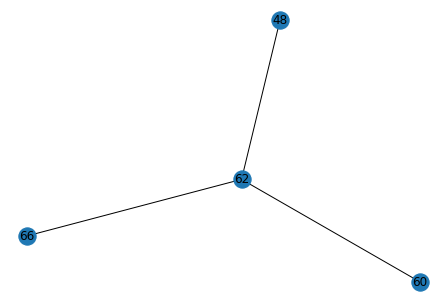

match_branches = [[60, 66]]
edges_to_delete (resolve crossover) = [[48, 60], [48, 62], [48, 66], [60, 62], [62, 66]]
edges_to_create (resolve crossover) = [[60, 66]]
curr_limb.deleted_edges 5 =[[32, 33], [32, 35], [33, 36], [35, 36], [57, 62], [57, 63], [62, 64], [63, 64]]
Skipping endnode 42 because skeletal distance was 667.7304046780656 and threshold was 2500
skip_nodes = [42]
edges_to_delete (cut_limb_network) = [[48, 60], [48, 62], [48, 66], [60, 62], [62, 66]]
edges_to_create = [[60, 66]]
Number of connected components = 6
Comp 0 = {0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 33, 35, 37, 38, 40, 41, 42, 45, 49, 51, 58, 59, 62, 63, 65}
Comp 1 = {2, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 36, 39}
Comp 2 = {64, 67, 43, 44, 46, 47, 50, 52, 53, 54, 56, 57}
Comp 3 = {48}
Comp 4 = {66, 60, 61, 55}
Comp 5 = {34}
curr_limb_copy.deleted_edges = [[32, 33], [32, 35], [33, 36], [35, 36], [57, 62], [57, 63], [62, 64], [63, 64], [48, 60], [48, 62], [48, 66], [

  Edge: [11  7]: curr_angle = 124.49
  Edge: [7 8]: curr_angle = 79.75
  Edge: [ 8 17]: curr_angle = 81.94
  Edge: [17 14]: curr_angle = 12.99
  Edge: [14 15]: curr_angle = 45.12

Total time for doubling_back = 0.2660989761352539
There were 1 edges that passed doubling back threshold of 100
Winning edge [11  7] had a doubling back of 124.4947667302454
***inside resolve crossover!!!!****
coordinate_branches = [5, 7, 11]
5 = red
7 = aqua
11 = purple
Angle between 5 and 7 = 68.94 
Angle between 5 and 11 = 30.67 
Angle between 7 and 11 = 118.91 
Final Matches = [[5, 11]]
matched_branches_revised = [[5, 11]]
Original graph


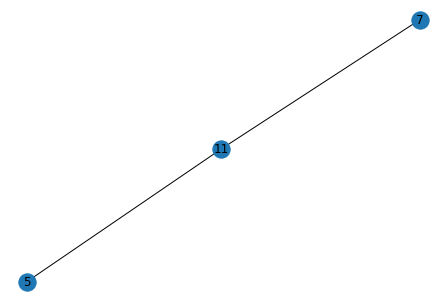

match_branches = [[5, 11]]
edges_to_delete (resolve crossover) = [[5, 7], [7, 11]]
edges_to_create (resolve crossover) = [[5, 11]]
edges_to_delete (cut_limb_network) = [array([5, 7]), array([ 7, 11])]
edges_to_create = [[5, 11]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18}
Comp 1 = {11, 5}
curr_limb_copy.deleted_edges = [array([5, 7]), array([ 7, 11])]
curr_limb_copy.created_edges = [[5, 11]]
After get best cut: cut_edges = [array([5, 7]), array([ 7, 11])], added_edges = [[5, 11]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18]), array([11,  5])]


 ------ Total time for Splitting 8646

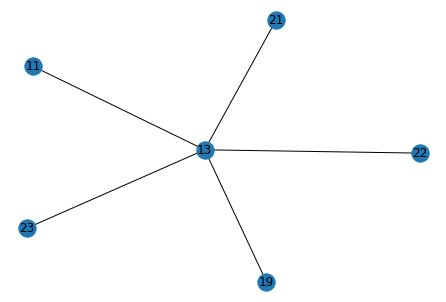

match_branches = [[11, 23], [19, 21], [13, 22]]
edges_to_delete (resolve crossover) = [[11, 13], [11, 19], [11, 21], [11, 22], [13, 19], [13, 21], [13, 23], [19, 22], [19, 23], [21, 22], [21, 23], [22, 23]]
edges_to_create (resolve crossover) = [[11, 23], [19, 21], [13, 22]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[11, 13], [11, 19], [11, 21], [11, 22], [13, 19], [13, 21], [13, 23], [19, 22], [19, 23], [21, 22], [21, 23], [22, 23]]
edges_to_create = [[11, 23], [19, 21], [13, 22]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54}
Comp 1 = {11, 23}
Comp 2 = {3, 19, 12, 21}
Comp 3 = {20}
curr_limb_copy.deleted_edges = [[11, 13], [11, 19], [11, 21], [11, 22], [13, 19], [13, 21], [13, 23], [19, 22], [19, 23], [21, 22], [21, 23], [22, 23]]
curr_limb_copy.created_edges = [[1

  Edge: [15 16]: curr_angle = 22.89
  Edge: [16 14]: curr_angle = 24.17
  Edge: [14 13]: curr_angle = 62.42
  Edge: [13 22]: curr_angle = 16.59
  Edge: [22 26]: curr_angle = 39.37
  Edge: [26 27]: curr_angle = 42.4
  Edge: [27 31]: curr_angle = 22.53
  Edge: [31 35]: curr_angle = 7.98
  Edge: [35 37]: curr_angle = 26.31
  Edge: [37 36]: curr_angle = 22.68

Total time for doubling_back = 0.9918878078460693

Attempting the width jump check (attempting from both sides)
  Edge: [15 16]: jump = -3.5
  Edge: [16 14]: jump = 23.18
  Edge: [14 13]: jump = -56.79
  Edge: [13 22]: jump = -177.66
  Edge: [22 26]: jump = 91.02
  Edge: [26 27]: jump = 315.9
Adding error edge [26 27] because width jump was 315.90125756567807
  Edge: [27 31]: jump = 9.4
  Edge: [31 35]: jump = 58.28
  Edge: [35 37]: jump = 89.97
  Edge: [37 36]: jump = 112.31
Total time for width = 0.9619309902191162
Path starting at 15 had err_edges: [[26, 27]]
  Edge: [36 37]: jump = -112.31
  Edge: [37 35]: jump = -89.97
  Edge: [

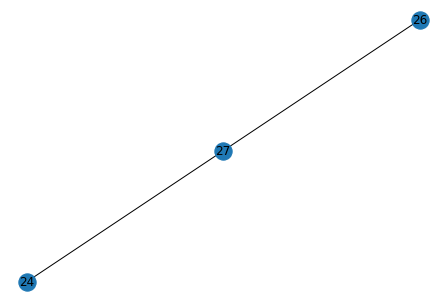

match_branches = []
edges_to_delete (resolve crossover) = [[24, 26], [24, 27], [26, 27]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([24, 26]), array([24, 27]), array([26, 27])]
edges_to_create = []
Number of connected components = 6
Comp 0 = {0, 1, 4, 6, 7, 8, 13, 14, 15, 16, 17, 22, 26, 28, 29, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54}
Comp 1 = {11, 23}
Comp 2 = {3, 19, 12, 21}
Comp 3 = {2, 5, 10, 18, 24}
Comp 4 = {32, 33, 34, 35, 36, 37, 38, 39, 40, 9, 41, 43, 42, 25, 27, 30, 31}
Comp 5 = {20}
curr_limb_copy.deleted_edges = [[11, 13], [11, 19], [11, 21], [11, 22], [13, 19], [13, 21], [13, 23], [19, 22], [19, 23], [21, 22], [21, 23], [22, 23], array([24, 26]), array([24, 27]), array([26, 27])]
curr_limb_copy.created_edges = [[11, 23], [19, 21], [13, 22]]
After get best cut: cut_edges = [array([24, 26]), array([24, 27]), array([26, 27])], added_edges = []
total_soma_paths_to_cut = [[11, 13], [11, 19], [11, 21], [11, 22], [13, 19], [13, 21], [

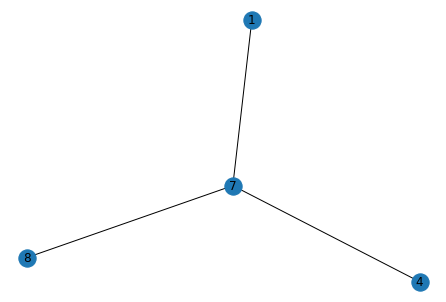

match_branches = [[1, 7], [4, 8]]
edges_to_delete (resolve crossover) = [[1, 4], [1, 8], [4, 7], [7, 8]]
edges_to_create (resolve crossover) = [[1, 7], [4, 8]]
curr_limb.deleted_edges 5 =[[11, 13], [11, 19], [11, 21], [11, 22], [13, 19], [13, 21], [13, 23], [19, 22], [19, 23], [21, 22], [21, 23], [22, 23], array([24, 26]), array([24, 27]), array([26, 27])]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 4], [1, 8], [4, 7], [7, 8]]
edges_to_create = [[1, 7], [4, 8]]
Number of connected components = 8
Comp 0 = {4, 8, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 29}
Comp 1 = {0, 1, 7, 13, 14, 15, 16, 17, 22, 26, 28}
Comp 2 = {11, 23}
Comp 3 = {3, 19, 12, 21}
Comp 4 = {2, 5, 10, 18, 24}
Comp 5 = {32, 33, 34, 35, 36, 37, 38, 39, 40, 9, 41, 43, 42, 25, 27, 30, 31}
Comp 6 = {6}
Comp 7 = {20}
curr_limb_copy.deleted_edges = [[11, 13], [11, 19], [11, 21], [11, 22], [13, 19], [13, 21], [13, 23], [19, 22], [19, 23], [21, 22], [21, 23], [22, 23], array([24, 26]), array([24, 27]), array([26

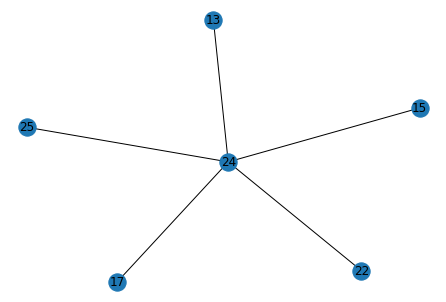

match_branches = [[13, 25], [15, 24], [17, 22]]
edges_to_delete (resolve crossover) = [[13, 15], [13, 17], [13, 22], [13, 24], [15, 17], [15, 22], [15, 25], [17, 24], [17, 25], [22, 24], [22, 25], [24, 25]]
edges_to_create (resolve crossover) = [[13, 25], [15, 24], [17, 22]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[13, 15], [13, 17], [13, 22], [13, 24], [15, 17], [15, 22], [15, 25], [17, 24], [17, 25], [22, 24], [22, 25], [24, 25]]
edges_to_create = [[13, 25], [15, 24], [17, 22]]
Number of connected components = 4
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21.0, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34.0, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92}
Comp 1 = {25, 13}
Comp 2 = {18}
Comp 3 = {23}
curr_limb_copy.deleted_edges =

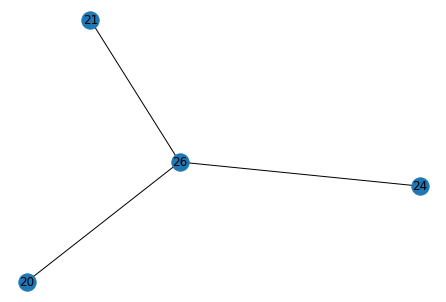

match_branches = []
edges_to_delete (resolve crossover) = [[20, 21], [20, 24], [20, 26], [21, 24], [21, 26], [24, 26]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[[13, 15], [13, 17], [13, 22], [13, 24], [15, 17], [15, 22], [15, 25], [17, 24], [17, 25], [22, 24], [22, 25], [24, 25]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[20, 21], [20, 24], [20, 26], [21, 24], [21, 26], [24, 26]]
edges_to_create = []
Number of connected components = 6
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 19, 26, 27, 28, 29, 30, 31, 32, 33, 34.0, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92}
Comp 1 = {17, 20, 21.0, 22}
Comp 2 = {24, 15}
Comp 3 = {25, 13}
Comp 4 = {18}
Comp 5 = {23}
curr_limb_copy.deleted_edges = [[13, 15], [13, 17], [13, 22], [13, 24], [15, 17], [15, 22], [15,

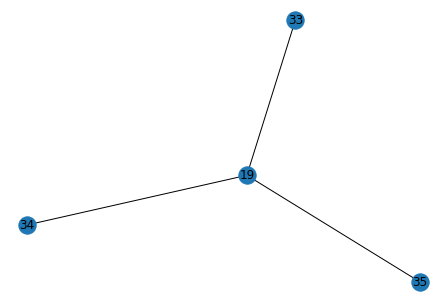

match_branches = [[19, 35]]
edges_to_delete (resolve crossover) = [[19, 33], [19, 34], [33, 34], [33, 35], [34, 35]]
edges_to_create (resolve crossover) = [[19, 35]]
curr_limb.deleted_edges 5 =[[13, 15], [13, 17], [13, 22], [13, 24], [15, 17], [15, 22], [15, 25], [17, 24], [17, 25], [22, 24], [22, 25], [24, 25], [20, 21], [20, 24], [20, 26], [21, 24], [21, 26], [24, 26]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[19, 33], [19, 34], [33, 34], [33, 35], [34, 35]]
edges_to_create = [[19, 35]]
Number of connected components = 7
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 19, 27, 28, 29, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92}
Comp 1 = {33, 34.0, 26, 30, 31}
Comp 2 = {17, 20, 21.0, 22}
Comp 3 = {24, 15}
Comp 4 = {25, 13}
Comp 5 = {18}
Comp 6 = {23}
curr_limb_copy.deleted

  Edge: [14 27]: curr_angle = 28.43
  Edge: [27 16]: curr_angle = 17.91
  Edge: [16 19]: curr_angle = 33.8
  Edge: [19 35]: curr_angle = 9.13
  Edge: [35 40]: curr_angle = 37.85
  Edge: [40 36]: curr_angle = 59.91
  Edge: [36 37]: curr_angle = 139.24
  Edge: [37 54]: curr_angle = 20.8
  Edge: [54 59]: curr_angle = 45.94
  Edge: [59 67]: curr_angle = 21.08
  Edge: [67 68]: curr_angle = 59.87
  Edge: [68 69]: curr_angle = 21.63
  Edge: [69 71]: curr_angle = 42.99
  Edge: [71 74]: curr_angle = 37.74
  Edge: [74 75]: curr_angle = 17.21

Total time for doubling_back = 1.0157783031463623
There were 1 edges that passed doubling back threshold of 100
Winning edge [36 37] had a doubling back of 139.24341555082304
***inside resolve crossover!!!!****
coordinate_branches = [12, 36, 37]
12 = red
36 = aqua
37 = purple
Angle between 12 and 36 = 59.97 
Angle between 12 and 37 = 30.96 
Angle between 36 and 37 = 141.24 
Final Matches = [[12, 37]]
matched_branches_revised = [[12, 37]]
Original graph


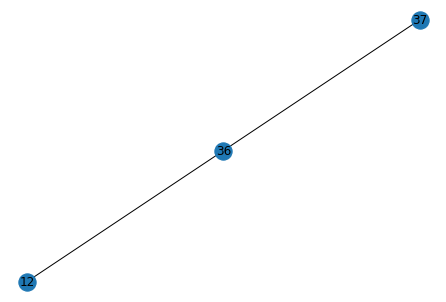

match_branches = [[12, 37]]
edges_to_delete (resolve crossover) = [[12, 36], [36, 37]]
edges_to_create (resolve crossover) = [[12, 37]]
edges_to_delete (cut_limb_network) = [array([12, 36]), array([36, 37])]
edges_to_create = [[12, 37]]
Number of connected components = 8
Comp 0 = {1, 2, 12, 37, 54, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90}
Comp 1 = {0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16, 19, 27, 28, 29, 32, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 91, 92}
Comp 2 = {33, 34.0, 26, 30, 31}
Comp 3 = {17, 20, 21.0, 22}
Comp 4 = {24, 15}
Comp 5 = {25, 13}
Comp 6 = {18}
Comp 7 = {23}
curr_limb_copy.deleted_edges = [[13, 15], [13, 17], [13, 22], [13, 24], [15, 17], [15, 22], [15, 25], [17, 24], [17, 25], [22, 24], [22, 25], [24, 25], [20, 21], [20, 24], [20, 26], [21, 24], [21, 26], [24, 26], [19, 33], [19, 34], [33, 34], [33, 35], [34, 35], array([12, 36]), arr

In [12]:
start_time = time.time()
if not test_mode:
    time.sleep(random.randint(0, 800))
print('Populate Started')
if not test_mode:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
else:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
print('Populate Done')

print(f"Total time for NeuronSplitSuggestions populate = {time.time() - start_time}")

In [13]:
# import proofreading_utils as pru
# pru = reload(pru)
# du.create_suggested_splits_neuroglancer_spreadsheet(output_type="local")